In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
np.random.seed(4) 

In [3]:
def rana5D(x1,x2,x3,x4,x5):
    y1= (x1* np.cos(np.sqrt(abs(x2+x1+1))) *np.sin(np.sqrt(abs(x2-x1+1)))) + ((1+x2) * np.cos(np.sqrt(abs(x2-x1+1))) *np.sin(np.sqrt(abs(x2+x1+1))))
    y2= (x2* np.cos(np.sqrt(abs(x3+x2+1))) *np.sin(np.sqrt(abs(x3-x2+1)))) + ((1+x3) * np.cos(np.sqrt(abs(x3-x2+1))) *np.sin(np.sqrt(abs(x3+x2+1))))
    y3= (x3* np.cos(np.sqrt(abs(x4+x3+1))) *np.sin(np.sqrt(abs(x4-x3+1)))) + ((1+x4) * np.cos(np.sqrt(abs(x4-x3+1))) *np.sin(np.sqrt(abs(x4+x3+1))))
    y4= (x4* np.cos(np.sqrt(abs(x5+x4+1))) *np.sin(np.sqrt(abs(x5-x4+1)))) + ((1+x5) * np.cos(np.sqrt(abs(x3-x4+1))) *np.sin(np.sqrt(abs(x5+x4+1))))
    return y1+y2+y3+y4

def upscale_x(x):
    x_upscaled = 500*(2*x -1)
    return x_upscaled

def clip(x):
    if x>1:
        return 1
    if x<0:
        return 0
    else:
        return x
    
# generate new trial solutions by Parks, 1990
def gen_x_parks(x,D,T):
    
    D_new= np.zeros((5,5))
    x_new= np.zeros(5)
    R_kk=np.array([D[0][0]*(np.random.uniform(-1,1)) , \
                   D[1][1]*(np.random.uniform(-1,1)),\
                   D[2][2]*(np.random.uniform(-1,1)),\
                   D[3][3]*(np.random.uniform(-1,1)),\
                   D[4][4]*(np.random.uniform(-1,1))])
    x_new[0]=clip(x[0]+R_kk[0])
    x_new[1]=clip(x[1]+R_kk[1])
    x_new[2]=clip(x[2]+R_kk[2])
    x_new[3]=clip(x[3]+R_kk[3])
    x_new[4]=clip(x[4]+R_kk[4])
    
    #change in obj fn value
    df= rana5D(upscale_x(x_new[0]),upscale_x(x_new[1]),upscale_x(x_new[2]),upscale_x(x_new[3]),upscale_x(x_new[4])) - rana5D(upscale_x(x[0]),upscale_x(x[1]),upscale_x(x_new[2]),upscale_x(x_new[3]),upscale_x(x_new[4]))
    #actual step size:
    d= np.sqrt(R_kk[0]**2+ R_kk[1]**2+R_kk[2]**2+R_kk[3]**2+R_kk[4]**2)
    R_kk= np.fabs(R_kk)
    #update D
    D_new= np.zeros((5,5))
    D_new[0][0]= (1-damp)*D[0][0] + damp*weight*abs(R_kk[0])
    D_new[1][1]= (1-damp)*D[1][1] + damp*weight*abs(R_kk[1])
    D_new[2][2]= (1-damp)*D[2][2] + damp*weight*abs(R_kk[2])
    D_new[3][3]= (1-damp)*D[3][3] + damp*weight*abs(R_kk[3])
    D_new[4][4]= (1-damp)*D[4][4] + damp*weight*abs(R_kk[4])
    #probability of accepting an increase in f
    p= np.exp(-df/(T*d))
    #decrease in f, just accept
    if df<0:
        return x_new, D_new
    #accept with prob p if f increases
    elif p > np.random.uniform(0,1):
        return x_new, D_new
    else:
        return x, D
        
def T0_estimate_white(x,D,Lk_init):
    #by white 1984, T0= std of list of f values observed in initial search.
    #Lk_init= number of initial search trials
    
    f_list=[]
    
    for i in range(0,Lk_init):
        D_new= np.zeros((5,5))
        x_new= np.zeros(5)
        R_kk=np.array([D[0][0]*(np.random.uniform(-1,1)) ,\
                       D[1][1]*(np.random.uniform(-1,1)),\
                       D[2][2]*(np.random.uniform(-1,1)),\
                       D[3][3]*(np.random.uniform(-1,1)),\
                       D[4][4]*(np.random.uniform(-1,1))])

        x_new[0]=clip(x[0]+R_kk[0])
        x_new[1]=clip(x[0]+R_kk[1])
        x_new[2]=clip(x[2]+R_kk[2])
        x_new[3]=clip(x[3]+R_kk[3])
        x_new[4]=clip(x[4]+R_kk[4])
        
        R_kk= np.fabs(R_kk)
        
        D_new[0][0]= (1-damp)*D[0][0] + damp*weight*R_kk[0]
        D_new[1][1]= (1-damp)*D[1][1] + damp*weight*R_kk[1]
        D_new[2][2]= (1-damp)*D[2][2] + damp*weight*abs(R_kk[2])
        D_new[3][3]= (1-damp)*D[3][3] + damp*weight*abs(R_kk[3])
        D_new[4][4]= (1-damp)*D[4][4] + damp*weight*abs(R_kk[4])
        #list new f values, needed for T0 estimation
        f= rana5D(upscale_x(x_new[0]),upscale_x(x_new[1]),\
                  upscale_x(x_new[2]),upscale_x(x_new[3]),\
                  upscale_x(x_new[4]))
        f_list.append(f)
        x= x_new
        D= D_new
    
    T0= np.std(f_list)
    return T0

def T0_estimate_Kirk(x,D,Lk_init):
    #by Kirk 1984
    #Lk_init= number of initial search trials
    df_list=[]
    for i in range(0,Lk_init):
        D_new= np.zeros((5,5))
        x_new= np.zeros(5)
        R_kk=np.array([D[0][0]*(np.random.uniform(-1,1)) , \
                       D[1][1]*(np.random.uniform(-1,1)),\
                       D[2][2]*(np.random.uniform(-1,1)),\
                       D[3][3]*(np.random.uniform(-1,1)),\
                       D[4][4]*(np.random.uniform(-1,1))])
        x_new[0]=clip(x[0]+R_kk[0])
        x_new[1]=clip(x[0]+R_kk[1])
        x_new[2]=clip(x[2]+R_kk[2])
        x_new[3]=clip(x[3]+R_kk[3])
        x_new[4]=clip(x[4]+R_kk[4])
        
        R_kk= np.fabs(R_kk)
        D_new[0][0]= (1-damp)*D[0][0] + damp*weight*R_kk[0]
        D_new[1][1]= (1-damp)*D[1][1] + damp*weight*R_kk[1]
        D_new[2][2]= (1-damp)*D[2][2] + damp*weight*abs(R_kk[2])
        D_new[3][3]= (1-damp)*D[3][3] + damp*weight*abs(R_kk[3])
        D_new[4][4]= (1-damp)*D[4][4] + damp*weight*abs(R_kk[4])
        #list of df values, needed for T0 estimation
        df= rana5D(upscale_x(x_new[0]),upscale_x(x_new[1]),\
                   upscale_x(x_new[2]),upscale_x(x_new[3]),\
                   upscale_x(x_new[4])) - \
            rana5D(upscale_x(x[0]),upscale_x(x[1]),\
               upscale_x(x_new[2]),\
               upscale_x(x_new[3]),upscale_x(x_new[4]))
        if df>0:
            df_list.append(df)
        #update x and D also
        x= x_new
        D= D_new 
    T0= -np.mean(df_list)/np.log(0.8)
    return T0


# SA combined:
Lk_init=100
def SA_by_parks(k,Lk):
#k= number of Steps(MCs), Lkk=length of each step (MCs)
    f_list=[]
    x_list=[]
    #x0 generated randomly from seed
    x0= np.array([np.random.rand(),np.random.rand(),np.random.rand(),\
                  np.random.rand(),np.random.rand()])
    D0= np.zeros((5,5))
    D0[0][0]= x0[0]
    D0[1][1]= x0[1]
    D0[2][2]= x0[2]
    D0[3][3]= x0[3]
    D0[4][4]= x0[4]
    #initialise T
    T= T0_estimate_white(x0,D0,Lk_init)
    #first update of x and D
    x,D= gen_x_parks(x0,D0,T)
    #iterate
    for i in range(0,k):
        for j in range(0,Lk):
            XX,DD= gen_x_parks(x,D,T)
            if np.any(x != XX)== True:
                x,D = XX,DD
                f_list.append(rana5D(upscale_x(x[0]),\
                                     upscale_x(x[1]),\
                                     upscale_x(x[2]),\
                                     upscale_x(x[3]),\
                                     upscale_x(x[4])))
                x_list.append((upscale_x(x[0]),\
                               upscale_x(x[1]),\
                               upscale_x(x[2]),\
                               upscale_x(x[3]),\
                               upscale_x(x[4])))
        #T decrement outside MC
        T*= 0.95
       
    f_min=min(f_list)
    x_coords=x_list[f_list.index(f_min)]
    
    return f_list, x_list, f_min, x_coords
    

In [4]:
#define params
damp=0.1
weight=2.1
Lk_init=100
k= 70
Lk= 129
num_iter=50 #run SA 50 times

In [5]:
obj_fn_list=[]
f_min_list=[]
x_coords_list=[]
for i in range(0,num_iter):
    RESULTS=SA_by_parks(k,Lk)
    f_min_list.append(RESULTS[2])
    x_coords_list.append(RESULTS[3])
    obj_fn_list.append(RESULTS[0])
f_min_final= min(f_min_list)
x_coord_final= x_coords_list[f_min_list.index(f_min_final)]

print(f_min_final, x_coord_final)


-2004.3309069383397 (500.0, 475.7847593931671, 500.0, -497.25510060712776, -500.0)


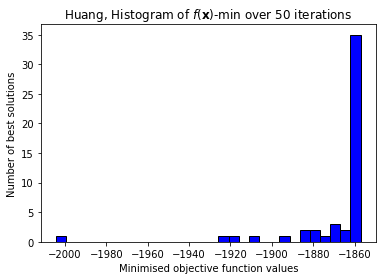

In [6]:
#plot histogram of f_min_list over num_iter iterations
plt.hist(f_min_list, 30, color='blue', histtype='bar', ec='black')
plt.title('Huang, Histogram of $f(\mathbf{x})$-min over 50 iterations')
plt.xlabel('Minimised objective function values')
plt.ylabel('Number of best solutions')
plt.show()

In [7]:
print(np.std(f_min_list))
print(np.mean(f_min_list))

24.83750319445244
-1867.6738319988365
